# MODEL PROJECT

## 2. Model description

One way to construct a theory of endogenous growth is to eliminate the long-run tendency for capital to experience diminishing returns. We consider the AK model, in which the returns to capital are always constant, and we considered technologies in which the returns to capital diminished but asymptotically approached a positive constant. We begin our analysis by combining the AK technology with optimizing behavior of households and firms.


In [1]:
import numpy as np
import scipy as sp
import math
from scipy import optimize
import sympy as sm
from scipy import linalg
from sympy import Derivative
from scipy import interpolate
import scipy.integrate as quad
from scipy.integrate import odeint
import scipy.special as special
from scipy.integrate import quad
from sympy import symbol,function

#autoreload model when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [2]:
c = sm.symbols('c')
alpha = sm.symbols('alpha')
theta = sm.symbols('theta')
e = sm.symbols('e')
rho = sm.symbols('rho') #discount factor
n = sm.symbols('n')
r = sm.symbols('r')
w = sm.symbols('w')
a=sm.symbols('a')
t= sm.symbols('t')
u= sm.symbols('u')
A= sm.symbols('A')
k= sm.symbols('k')
K=sm.symbols('K')
L=sm.symbols('L')
delta = sm.symbols('delta')

### Behavior of household

We identify the most important variables:

- *c* is the consumption
- $\alpha$ is the assets per person
- *r* is the interest rate w is the wage rate
- *w* is the wage rate
- *n* is the growth rate of population

Infinite-lived households maximize utility as given by

$$U= \int_{0}^{\infty} e^{-(\rho-n)t}\left[\frac{c^{1-\theta}-1}{1-\theta}\right]dt$$

subject to constraint

$$\dot{\alpha} = (r-n)\alpha+w-c$$

We impose the no Ponzi-game condition (ruling out chain-letter debt finance)

$$\lim_{t \to \infty} \bigg\{ \alpha(t)exp\left[-\int_{0}^{t}[r(v)-n]dv\right] \bigg\} \geq 0$$

The condition for optimization of the above problem is

$$\frac{\dot{c}}{c}=\frac{1}{\theta}(r-\rho)$$

And the transversality condition

$$\lim_{t \to \infty} \bigg\{ \alpha(t)exp\left[-\int_{0}^{t}[r(v)-n]dv \right] \bigg\} = 0$$

We can use sympy to find the  analytical expression for the optimal value
First we define all *symbols*:

In [5]:
def integrand(t, rho, theta, n, c):
    return sm.exp(-t*(rho-n))*((c**(1-theta)-1)/(1-theta))

def expint(rho, theta, n, c):
    return quad(integrand, 0, np.inf, args=(rho, theta, n, c))[0]

def ut(c):
    if theta != 1:
        return (c**(1-theta)-1)/(1-theta)
    else:
        return np.log(c)

In [6]:
theta = 0.5
ut(10)

4.324555320336759

In [19]:
c1 = sm.symbols('c1')
c2 = sm.symbols('c2')
def U(c1, c2):
    return ut(c1) + np.exp(-rho) * ut(c2)


C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\maria\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


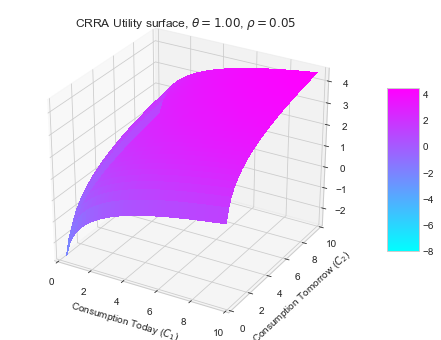

In [22]:
# create a new Figure object 
fig = plt.figure(figsize=(8,6))

# create a 3D Axes object
ax = fig.gca(projection='3d', elev=30, azim=300)

# create a grid of (x,y) values which we will pass to function
C_today = np.arange(0, 10, 0.25)
C_tomorrow = np.arange(0, 10, 0.25)
c1, c2 = np.meshgrid(C_today, C_tomorrow)

# Choose parameter values
theta, rho = 1.0, 0.05

# we will actually plot output
utility = U(c1, c2)

# note the use of the new plot command!
utility_surface = ax.plot_surface(c1, c2, utility, rstride=1, cstride=1, cmap=mpl.cm.cool, 
                                  linewidth=0, vmin=-8, vmax=np.max(utility), antialiased=False)

# adjust axis limits
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# don't forget to label your axes!
ax.set_xlabel(r'Consumption Today ($C_{1}$)')
ax.set_ylabel(r'Consumption Tomorrow ($C_{2}$)')

# add a title!
ax.set_title(r'CRRA Utility surface, $\theta=%.2f$, $\rho=%.2f$' %(theta, rho))

# add a colorbar
fig.colorbar(utility_surface, shrink=0.5, aspect=5)

# display the plot!
plt.show()

Optimal choice of C1 is:        4.985488293001099
Optimal choice of C2 is:        5.014874499673874
Utility from optimal bundle is: 1.2080381646963043


C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


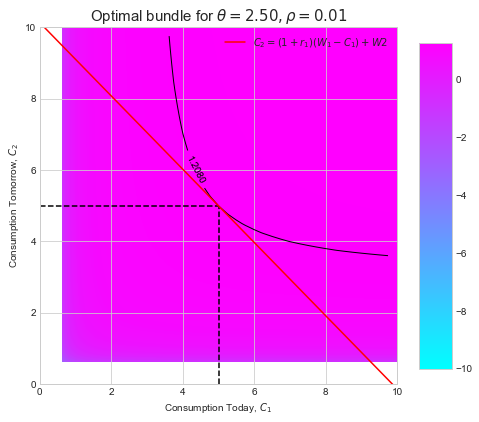

In [25]:
r1 =sm.symbols('r1')
w1 =sm.symbols('w1')
w2 =sm.symbols('w2')

# define parameter values
theta, rho = 2.5, 0.01
 
# Specify some prices (i.e., wages and interest rates) all of which agent take as given
w1, w2, r1 = 5, 5, 0.025



# Define implicit functions using the FOC
def F1(c1, c2): 
    """
    
    Implicit function derived from the Euler equation.
    """
    return c1**(-theta) - np.exp(-rho) * (1 + r1) * c2**(-theta)
    
def F2(c1, c2): 
    """
    
    Implicit function derived from the budget constraint.
    """
    return w1 + (1 / (1 + r1)) * w2 - c1 - (1 / (1 + r1)) * c2

# <codecell>

# First need to define a function that fsolve can optimize
def optimalBundle(X):
    out = [F1(X[0], X[1])]
    out.append(F2(X[0], X[1]))
    return out

# Apply fsolve()...note that we need to give the algorithm a decent guess!
C1_init, C2_init = 0.5, 0.5
C1_Star, C2_Star = optimize.fsolve(func=optimalBundle, x0=(C1_init, C2_init))
U_Star = U(C1_Star, C2_Star)

# <codecell>

# what is the optimal bundel?
print ("Optimal choice of C1 is:       ", C1_Star)
print ("Optimal choice of C2 is:       ", C2_Star)
print ("Utility from optimal bundle is:", U_Star)

# <codecell>

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# we will actually plot utility
utility = U(c1, c2)

# create the contour plot
utility_surface = ax.imshow(utility, interpolation='gaussian', origin='lower', cmap=mpl.cm.cool, 
                            vmin=-10, vmax=np.max(utility), extent=(0, 10, 0, 10))

# plot the budget constraint
consumption_today = np.linspace(0, 10, 100)
ax.plot(consumption_today, (1 + r1) * (w1 - consumption_today) + w2, 
        color='r', label=r'$C_{2}=(1 + r_{1})(W_{1} - C_{1}) + W2$')

# demarcate the indifference curve...
CS = ax.contour(c1, c2, utility, np.array([U_Star]), colors='k', linewidths=1, linestyles='solid')
ax.clabel(CS, inline=1, fmt='%1.4f')

# mark the optimal bundle
ax.hlines(C1_Star, 0, C2_Star, linestyle='dashed')
ax.vlines(C2_Star, 0, C1_Star, linestyle='dashed')

# axes, labels, title, colorbar etc.
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel(r'Consumption Today, $C_{1}$')
ax.set_ylabel(r'Consumption Tomorrow, $C_{2}$')
ax.set_title(r'Optimal bundle for $\theta=%.2f, \rho=%.2f$' %(theta, rho), fontsize=15)
ax.legend(loc=1, frameon=False)
fig.colorbar(utility_surface, shrink=0.75, aspect=10)

# save and plot figure!
plt.show()

## Behaviour of firm

Our firm has a linear production function:
$$y=f(k)=Ak$$
where A>0. 

We now check that in this case the marginal product of capital is not diminishing ($f''=0$) and the Inada conditions are violated because $lim_{t \to \infty} [f'(k)] \neq 0$.

In [77]:
# Production function
prod = A*K
deriv= Derivative(prod, K)
deriv.doit()

# Define profit function
profit = prod - (r+delta)*K -w*L
display(profit)

A*K - K*(delta + r) - L*w

The condition for profit maximization require the marginal product of capital to equal the rental price where the first is $A$ as previously computed. So the condition for profit maximization is:

In [97]:
foc = sm.Eq(sm.diff(profit,K),0)
display(foc)

Eq(A - delta - r, 0)

## Model equilibrium

From profit maximization, we can impose the equilibrium condition for the optimal consumption path, i.e. $r(t) = A-\delta$:
$$\gamma= \frac{\dot{c}(t)}{c(t)}= \sigma(A-\delta-\rho)$$
We can easily notice that for the consumption growth to be positive $A> \delta+\rho$.

In [33]:
# Check if consumption growth is positive

def negpos(A, delta, rho):
    if A > delta + rho:
       print(f'Consumption growth is positive')
    else:
       print(f'Consumption growth is negative')

negpos(1, 2, 1)

Consumption growth is negative


We now solve the differantial equation for the optimal consumption path. The result is:

$$c(t)=c(0)e^{[A-\delta-\rho]t}$$
where c(0) is consumption at time $t_0$.  

In [ ]:
# Solving differential equation for multiple values
A =2 
def model(c, t, sigma, delta, rho):
    dcdt = sigma**(A-delta-rho)
    return dcdt

#initial condition
c0 = 3

#time point
t=np.linspace(0,10,10) #start,f

# Solve ODEs
sigma= 0.1
delta= 0.3
rho= 0.9
c1 = odeint(model,c0,t, args=(sigma, delta, rho,))
sigma=0.2
delta=0.3
rho=0.9
c2 = odeint(model,c0,t, args=(sigma, delta, rho,))
sigma= 0.3
delta= 0.3
rho= 0.9
c3 = odeint(model,c0,t, args=(sigma, delta, rho,))

#plot results
plt.plot(t,c1,'r-', linewidth=2)
plt.plot(t,c2,'b--', linewidth=2)
plt.plot(t,c3,'g:', linewidth=2)
plt.xlabel('time')
plt.ylabel('c(t)')

Another important condition is to ensure that $\delta +\rho> (A-\delta)(1-\theta)+\theta*n+\delta$. In this way it is ensured that the attainable utility is bounded and the transversality condition holds.

In [35]:
#Check if utility is bounded

def to_bounded(delta, rho, A, theta, n):
    if delta+rho > (A-delta)*(1-theta)+theta*n+delta:
        print(f'Utility is bounded')
    else:
        print(f'Utility is not bounded')

to_bounded(1, 1, 2, 1, 3)

Moreover, in a closed economy, domestic production equals domestic demand (investment plus consumption) and capital is owned by residents implying $\alpha=k$.

To compute the growth rate of capital and output per worker, we divide eq.1 by k to get:
$$\frac{c}{k}=(A-\delta-n)-\frac{\dot{k}}{k}$$
In the steady state the groth rate of capital per person is constant. Therefore, the right-hand sideof the expression for $c/k$ is constant. Consequently th growth rate of capital per person (and hence the growth rate of output per person, $y$) equals the growth rate of consumption per capita already defined.

In [3]:
# note: documentation not written yet

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
import ipywidgets as widgets

class AkModel:

    ############
    # 1. setup #
    ############

    def __init__(self, name="", **kwargs):

        self.name = name
        self.baseline_parameters()
        self.update_parameters(kwargs)
        self.primitive_functions()

    def baseline_parameters(self):

        # a. model parameters
        self.rho = 0.90  # discount factor

        self.utility_function = "crra"
        self.sigma = 2  # crra coefficient

        self.production_function = "Ak"
        self.A = 2 # constant
        self.delta = 0.10  # depreciation rate

        # b. solution
        self.tau = 1e-7  # tolerance

        # c. saddle-path
        self.k0 = 1.00  # initial level of capital
        self.saddlepath_max_iter = 1000  # maximum number of iterations
        self.saddlepath_T = 1000  # maximum number of time periods to reach steady state

        # d. loci in phase diagram
        self.Nk = 200  # num of points
        self.k_max = 10  # maximum capital
        self.c_max = 7  # maximum consumption

        # e. simulation
        self.T = 500  # number of periods
        self.c_upper_fac = (
            5
        )  # exit if consumption > c_upper_fac*consumption in steady state
        self.c_lower_fac = (
            0.05
        )  # exit if consumption < c_lower_fac*consumption in steady state
        self.force_steady_state = 1e-4  # assume in steady state if close enough

        # f. misc
        self.do_print = True

    def update_parameters(self, kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def primitive_functions(self):

        eps = 1e-12  # minimum evaluation value to avoid errors

        # a. utility function
        if self.utility_function == "crra":
            if self.sigma == 1:
                self.u = lambda c: np.log(np.fmax(c, eps))
            else:
                self.u = lambda c: np.fmax(c, eps) ** (1 - self.sigma) / (
                    1 - self.sigma
                )
            self.u_prime = lambda c: np.fmax(c, eps) ** (-self.sigma)
        else:
            raise ValueError("unknown utility function")

        # b. production function
        if self.production_function == "Ak":
            self.f = lambda k: np.fmax(k, eps) * self.A
            self.f_prime = lambda k: self.A 
        else:
            raise ValueError("unknown production function")

    
    ######################
    # 2. model functions #
    ######################

    def k_plus_func(self, k, c):  # next period capital
        return k * (1 - self.delta) + self.f(k) - c

    def c_func(self, k, k_plus):  # backwards calculation of consumption
        return k * (1 - self.delta) + self.f(k) - k_plus

    def euler_LHS_func(self, c, c_plus):  # left-hand-side of euler equation
        return self.u_prime(c) / self.u_prime(c_plus)

    def euler_RHS_func(self, k_plus):  # right-hand-side of euler equation
        return self.rho * (1 + self.f_prime(k_plus) - self.delta)

    def r_func(self, k):  # interest rate
        return self.f_prime(k) - self.delta

    def w_func(self, k):  # wage
        return self.f(k) - self.f_prime(k) * k

    def Gamma(self, k, c):  # law-of-motion

        # i. capital
        k_plus = self.k_plus_func(k, c)

        # ii. consumption
        obj = lambda c_plus: self.euler_LHS_func(c, c_plus) - self.euler_RHS_func(
                k_plus
            )
        c_plus = optimize.fsolve(obj, c)[0]

        return k_plus, c_plus

    def dist_to_ss(self, k, c):  # distance to steady state

        return np.sqrt((k - self.k_star) ** 2 + (c - self.c_star) ** 2)

    
    ############
    # 3. solve #
    ############

    def find_steady_state(self):

        # a. objective euler_RHS_func == 1
        obj = lambda k: self.euler_RHS_func(k) - 1

        # b. find capital in steady state
        if self.production_function == "Ak":
            self.k_star = self.f_prime(1 / self.rho - 1 + self.delta)
        else:  # numerical solution
            self.k_star = optimize.fsolve(obj, 1)[0]

        # c. find implied steady consumption, interest rate and wage
        self.c_star = self.c_func(self.k_star, self.k_star)
        self.r_star = self.r_func(self.k_star)
        self.w_star = self.w_func(self.k_star)

        # d. print
        if self.do_print:
            print(f"k_star = {self.k_star:.4f}")
            print(f"c_star = {self.c_star:.4f}")
            print(f"r_star = {self.r_star:.4f}")
            print(f"w_star = {self.w_star:.4f}")

    def find_c0_on_saddlepath(self):  # initial consumption

        # a. initial capital
        k0 = self.k0

        # b. initial interval for consumption
        if k0 < self.k_star:
            c_low = 0
            c_high = self.c_func(k0, k0)
        else:
            c_low = self.c_func(k0, k0)
            c_high = self.f(k0) + k0 * (1 - self.delta)

        # for plotting
        self.c0_path = np.nan * np.ones(self.saddlepath_max_iter)
        self.c_high_path = np.nan * np.ones(self.saddlepath_max_iter)
        self.c_low_path = np.nan * np.ones(self.saddlepath_max_iter)

        # c. algorithm
        t = 0  # time
        it = 0  # iteration counter
        while it < self.saddlepath_max_iter:

            # i. initilize
            if t == 0:

                c0 = (c_low + c_high) / 2
                k = k0
                c = c0

                # for plotting
                self.c0_path[it] = c0
                self.c_low_path[it] = c_low
                self.c_high_path[it] = c_high

                it += 1

            t += 1  # increment time

            # ii. update and distance
            k, c = self.Gamma(k, c)
            dist = self.dist_to_ss(k, c)

            # iii. finish, forward or restart?
            if dist < self.tau or t > self.saddlepath_T:  # finish
                break
            elif k0 <= self.k_star:
                if c <= self.c_star and k <= self.k_star:
                    continue  # simulate forward
                else:  # restart
                    t = 0
                    if k > self.k_star:
                        c_low = c0  # c in [c0,c_high]
                    elif c > self.c_star:
                        c_high = c0  # c in [c_low,c0]
            else:
                if c >= self.c_star and k >= self.k_star:
                    continue  # simulate forward
                else:  # restart
                    t = 0
                    if k < self.k_star:
                        c_high = c0  # c in [c_low,c0]
                    elif c < self.c_star:
                        c_low = c0  # c in [c0,c_high]

        self.k0, self.c0 = k0, c0

        # d. print result
        if self.do_print:
            print(f"c0 = {self.c0:.4f}")

    def calculate_loci(self):

        # a. setup
        self.k_loci = dict()

        # c. k loci
        self.k_loci["x"] = np.linspace(0, self.k_max, self.Nk)
        self.k_loci["y"] = self.c_func(self.k_loci["x"], self.k_loci["x"])

    
    ###############
    # 4. simulate #
    ###############

    def simulate(self, c0=None):

        # a. allocate
        self.sim = dict()
        self.sim["k"] = np.empty(self.T)
        self.sim["c"] = np.empty(self.T)
        self.sim["r"] = np.empty(self.T)
        self.sim["w"] = np.empty(self.T)

        # b. time loop
        for t in range(self.T):

            # i. initial values
            if t == 0:

                self.sim["k"][t] = self.k0
                if c0 == None:
                    self.sim["c"][t] = self.c0  # model state
                else:
                    self.sim["c"][t] = c0  # input

            # ii. forward
            else:

                if (
                    self.dist_to_ss(self.sim["k"][t - 1], self.sim["c"][t - 1])
                    < self.force_steady_state
                ):
                    self.sim["k"][t] = self.k_star
                    self.sim["c"][t] = self.c_star
                else:
                    self.sim["k"][t], self.sim["c"][t] = self.Gamma(
                        self.sim["k"][t - 1], self.sim["c"][t - 1]
                    )

            # iii. prices
            self.sim["r"][t] = self.r_func(self.sim["k"][t])
            self.sim["w"][t] = self.w_func(self.sim["k"][t])

            # iv. disconvergence
            if (
                self.sim["c"][t] > self.c_upper_fac * self.c_star
                or self.sim["c"][t] < self.c_lower_fac * self.c_star
            ):
                self.sim["k"][t:] = np.nan
                self.sim["c"][t:] = np.nan
                break

    def optimal_initial_consumption_level(self):

        if not self.utility_function == "crra":
            raise ValueError("consumption level only implemented for crra utility")

        r_path = self.sim["r"]
        w_path = self.sim["w"]

        # a. initialize sums
        c_sum_rel = 1  # discounted sum of consumption relative to c0
        wealth_sum = (1 + r_path[0]) * self.k0 + w_path[0]  # discounted wealth

        # b. initialize factors
        c_fac = np.ones(self.T)  # growth factor of consumption
        R_fac = 1  # total discount factor

        # c. calculate sums
        for t in range(1, self.T):  # t = 1,2,3,...

            # i. factors
            c_fac[t] = (
                c_fac[t - 1]
                * ((1 + r_path[t]) * self.rho) ** (1 / self.sigma)
                / (1 + r_path[t])
            )
            R_fac /= 1 + r_path[t]

            # ii. sums
            c_sum_rel += c_fac[t]
            wealth_sum += w_path[t] * R_fac

        # d. return optimal consumption choice
        c0 = wealth_sum / c_sum_rel
        return c0

    
    ###########
    # 5. plot #
    ###########

    def plot_loci(self, ax, **kwargs):

        self.calculate_loci()
        self.plot_k_loci(ax, **kwargs)

        ax.set_xlim([0, self.k_max])
        ax.set_ylim([0, self.c_max])
        ax.set_xlabel("$k_t$")
        ax.set_ylabel("$c_t$")

    def plot_k_loci(self, ax, **kwargs):
        ax.plot(self.k_loci["x"], self.k_loci["y"], color="black", **kwargs)

    def plot_steady_state(self, ax, **kwargs):
        ax.plot(self.k_star, self.c_star, **kwargs)

    def plot_kc_path(self, ax, **kwargs):
        ax.plot(self.sim["k"], self.sim["c"], "-o", lw=0.5, MarkerSize=2, **kwargs)

    def plot_sim_time(self, ax, varname, **kwargs):
        ax.plot(self.sim[varname], "o", MarkerSize=2, **kwargs)


#####################
# interactive plots #
#####################

def interactive_phase_diagram():

    widgets.interact(
        phase_diagram,
        rho=widgets.FloatSlider(
            description="$\\rho$",
            min=0.90,
            max=0.99,
            step=0.01,
            value=0.97,
            continuous_update=False,
        ),
        sigma=widgets.FloatSlider(
            description="$\\sigma$",
            min=0.5,
            max=4,
            step=0.01,
            value=2,
            continuous_update=False,
        ),
        delta=widgets.FloatSlider(
            description="$\\delta$",
            min=0.05,
            max=0.20,
            step=0.01,
            value=0.10,
            continuous_update=False,
        ),
        A=widgets.FloatSlider(
            description="$\\A$",
            min=0.5,
            max=7,
            step=0.5,
            value=3,
            continuous_update=False,
        ),
        k0=widgets.FloatSlider(
            description="$k_0$",
            min=0,
            max=10,
            step=0.05,
            value=1,
            continuous_update=False,
        ),
    )

def phase_diagram(rho, sigma, delta, A, k0):

    # a. solve model
    model = AkModel(
        rho=rho, sigma=sigma, delta=delta, A=A, k0=k0, do_print=False
    )
    model.find_steady_state()
    model.find_c0_on_saddlepath()

    # b. setup figure
    fig = plt.figure(figsize=(12, 4), dpi=100)

    # c. phase diagram
    ax = fig.add_subplot(1, 2, 1)
    model.plot_loci(ax)
    model.simulate()
    model.plot_kc_path(ax)

    # d. time profile
    ax = fig.add_subplot(1, 2, 2)
    model.plot_sim_time(ax, "k")
    ax.plot([0, 100], [model.k_star, model.k_star], "--", color="black")
    ax.set_xlim([0, 100])
    ax.set_ylim([0, model.k_max])
    ax.set_xlabel("time")
    ax.set_ylabel("$k_t$")